# MSSEG-2 Subtraction Images

This file contains the code for the MSSEG challenge attempt using subtraction images.

## Setup environment

In [ ]:
!pip install -q "monai-weekly[all]"
!pip install -q matplotlib
%matplotlib inline


     |████████████████████████████████| 626 kB 6.3 MB/s 
     |████████████████████████████████| 2.9 MB 83.2 MB/s 
     |████████████████████████████████| 316 kB 86.8 MB/s 
     |████████████████████████████████| 221 kB 72.6 MB/s 
     |████████████████████████████████| 20.2 MB 273 kB/s 
     |████████████████████████████████| 70.2 MB 48 kB/s 
     |████████████████████████████████| 16.6 MB 63 kB/s 
     |████████████████████████████████| 53.9 MB 3.9 kB/s 
     |████████████████████████████████| 94.7 MB 4.5 kB/s 
     |████████████████████████████████| 15.0 MB 16.8 MB/s 


In [ ]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
    NormalizeIntensityd,
    ScaleIntensityRangePercentilesd,
    RandSpatialCropd,
    RandAxisFlipd,
    SpatialPadd,
    RandFlipd,
    RandRotate90d,
    RandShiftIntensityd,
    ScaleIntensityd,
    AddChanneld,
    AdjustContrastd,
    MaskIntensityd
)
# from monai.handlers.utils import from_engine
from monai.networks.nets import UNet, UNETR, SegResNet, VNet, DynUNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss, DiceCELoss, GeneralizedDiceLoss, FocalLoss, DiceFocalLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

## Setup data directory
These paths are specific to my Google Drive, need to be updated.
Requires preprocessed images


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_dir = '/content/drive/MyDrive/ML/MSSeg-2/colab'

/content/drive/MyDrive/ML/MSSeg-2/colab


In [ ]:
data_dir = '/content/drive/MyDrive/ML/MSSeg-2/LongitudinalMultipleSclerosisLesionSegmentationChallengeMiccai21/preprocessed'

## Get filepaths for required images and split into training and validation lists

In [ ]:
train_images = sorted(
    glob.glob(os.path.join(data_dir, "**/flair_time02_on_middle_space.nii.gz")))
first_images = sorted(
    glob.glob(os.path.join(data_dir, "**/flair_time01_on_middle_space.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "**/ground_truth.nii.gz")))

data_dicts = [
    {"image": image_name, "first_image": first_name, "label": label_name}
    for image_name, label_name, first_name in zip(train_images, train_labels, first_images)
]
train_files, val_files = data_dicts[:-8], data_dicts[-8:]



In [ ]:
len(train_files)

32

In [ ]:
len(val_files)

8

## Setup transforms for training and validation


In [ ]:
# Custom transform for creating a subtraction image
# This is simplistic, just subtract the first iamge from the second
# Better preprocessing could be done to align images / reduce impact of misalignment / intensity outliers
class DiffImagesd():
  
  def __init__(self, key1, key2, resultKey):
    self.key1 = key1
    self.key2 = key2
    self.resultKey = resultKey

  def __call__(self, data):
    data[self.resultKey] = data[self.key1] - data[self.key2]
    return data


In [ ]:
keys = ["image", "label", "first_image"]
keys_extended = list()
keys_extended.extend(keys)
keys_extended.append("diff_image")

train_transforms = Compose(
    [
        LoadImaged(keys=keys),
        EnsureChannelFirstd(keys=keys),
        Spacingd(keys=keys, pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest", "bilinear")),
        Orientationd(keys=keys, axcodes="RAS"),
     
        NormalizeIntensityd(keys=["image", "first_image"]),
        ScaleIntensityRangePercentilesd(["image", "first_image"], 1, 99, 0.0, 1.0, True, False),
     
        DiffImagesd(key1="image", key2="first_image", resultKey="diff_image"),
        ScaleIntensityd(keys=["diff_image"]),
     
        CropForegroundd(keys=keys_extended, source_key="image"),
        SpatialPadd(keys=keys_extended, spatial_size=(96, 96, 96)),

        RandSpatialCropd(keys=keys_extended, roi_size=(96, 96, 96), random_size=False),

        RandFlipd(keys=keys_extended, prob=0.2, spatial_axis=0),
        RandFlipd(keys=keys_extended, prob=0.2, spatial_axis=1),
        RandFlipd(keys=keys_extended, prob=0.2, spatial_axis=2),

        EnsureTyped(keys=keys_extended),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=keys),
        EnsureChannelFirstd(keys=keys),
        Spacingd(keys=keys, pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest", "bilinear")),
        Orientationd(keys=keys, axcodes="RAS"),
        
        NormalizeIntensityd(keys=["diff_image"]),
        ScaleIntensityRangePercentilesd(["image", "first_image"], 1, 99, 0.0, 1.0, True, False),
     
        DiffImagesd(key1="image", key2="first_image", resultKey="diff_image"),
        ScaleIntensityd(keys=["diff_image"]),

        CropForegroundd(keys=keys_extended, source_key="image"),
        EnsureTyped(keys=keys_extended),
    ]
)

## Check transforms in DataLoader

Validate what the transformations do to do images

In [ ]:
check_ds = Dataset(data=train_files, transform=train_transforms)
first_item = first(DataLoader(check_ds, batch_size=1))


torch.Size([1, 1, 96, 96, 96])


(tensor([18, 18, 18, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 21,
         21, 21]),
 tensor([14, 15, 15, 14, 14, 14, 15, 15, 15, 13, 13, 14, 14, 14, 14, 15, 15, 13,
         14, 15]),
 tensor([56, 55, 56, 55, 56, 57, 55, 56, 57, 57, 58, 55, 56, 57, 58, 57, 58, 57,
         57, 57]))

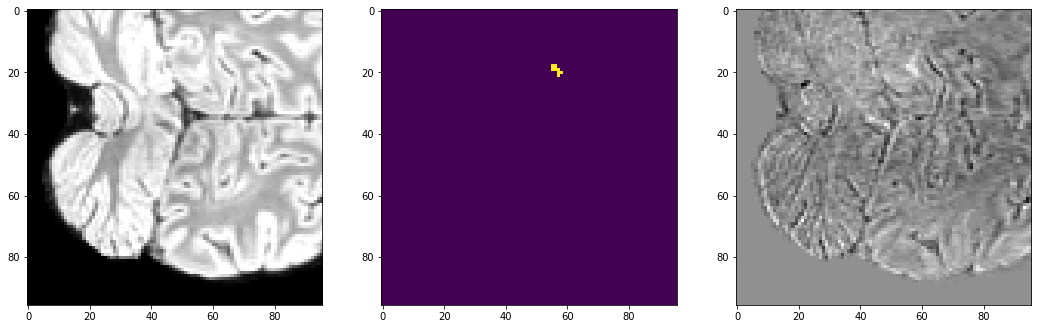

In [ ]:
print(first_item['image'].shape)

image = first_item['image'][0][0]
im_label = first_item['label'][0][0]
first_im = first_item['first_image'][0][0]
d_image = first_item['diff_image'][0][0]

layer = 15
plt.figure("check", (18, 6))
plt.subplot(1, 3, 1)
plt.imshow(image[:, layer,:], cmap="gray")
plt.subplot(1, 3, 2)
plt.imshow(im_label[:, layer, :])
plt.subplot(1, 3, 3)
plt.imshow(d_image[:, layer, :], cmap="gray")


# print out the dimensions which are marked as a lesion, helpful to select slice to look at
((im_label == 1).nonzero(as_tuple=True))


## Define Dataset and DataLoader for training and validation

We use CacheDataset to accelerate training and validation process, it's much faster than the regular Dataset.  
We cache all the data into memory as we have enough RAM. The results of every transformation before the first random transformation in the pipeline is applied and cached.


In [ ]:
train_ds = CacheDataset(
    data=train_files, transform=train_transforms,
    cache_rate=1.0, num_workers=2)

val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=2)

Loading dataset: 100%|██████████| 8/8 [00:22<00:00,  2.77s/it]


In [ ]:
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=2)

## Define the model, loss function and optimizer

In [ ]:
device = torch.device("cuda:0")

model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64),
    strides=(2, 2),
    num_res_units=3,
    norm=Norm.BATCH,
).to(device)


# Various loss functions one could use:

weights = torch.tensor([1., 100.]).to(device)
loss_function = DiceCELoss(to_onehot_y=True, softmax=True, include_background = True, ce_weight=weights)
# loss_function = DiceLoss(to_onehot_y=True, softmax=True, include_background = True)
# loss_function = FocalLoss(to_onehot_y=True, include_background = False)
# loss_function = GeneralizedDiceLoss(to_onehot_y=True, softmax=True, include_background = False)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-2)
dice_metric = DiceMetric(include_background=True, reduction="mean")

## Training process

In [ ]:
max_epochs = 250
val_interval = 5
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

# Transformations used post prediction so evaluation can be done
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, n_classes=2)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, n_classes=2)])

# standard training loop
for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0

    for batch_data in train_loader:
        step += 1

        inputs, labels = (
            batch_data["diff_image"].to(device),
            batch_data["label"].to(device),
        )

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = loss_function(outputs, labels)
        
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:

                val_inputs, val_labels = (
                    val_data["diff_image"].to(device),
                    val_data["label"].to(device),
                )

                roi_size = (96, 96, 96)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            metric_values.append(metric)

            # reset the status for next validation round
            dice_metric.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/250
1/4, train_loss: 1.4004
2/4, train_loss: 1.3763
3/4, train_loss: 1.3670
4/4, train_loss: 1.3739
epoch 1 average loss: 1.3794
----------
epoch 2/250
1/4, train_loss: 1.3510
2/4, train_loss: 1.3461
3/4, train_loss: 1.3281
4/4, train_loss: 1.3142
epoch 2 average loss: 1.3348
----------
epoch 3/250
1/4, train_loss: 1.3031
2/4, train_loss: 1.3153
3/4, train_loss: 1.2889
4/4, train_loss: 1.2900
epoch 3 average loss: 1.2993
----------
epoch 4/250
1/4, train_loss: 1.2840
2/4, train_loss: 1.2781
3/4, train_loss: 1.2642
4/4, train_loss: 1.2586
epoch 4 average loss: 1.2712
----------
epoch 5/250
1/4, train_loss: 1.2504
2/4, train_loss: 1.2761
3/4, train_loss: 1.2486
4/4, train_loss: 1.2456
epoch 5 average loss: 1.2552
saved new best metric model
current epoch: 5 current mean dice: 0.5569
best mean dice: 0.5569 at epoch: 5
----------
epoch 6/250
1/4, train_loss: 1.2360
2/4, train_loss: 1.2389
3/4, train_loss: 1.2235
4/4, train_loss: 1.2277
epoch 6 average loss: 1.2315
------

In [ ]:

print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.6586 at epoch: 45


## Plot the loss and metric

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

NameError: ignored

## Check best model output with the input image and label

label: tensor(0.)
output: tensor(1)


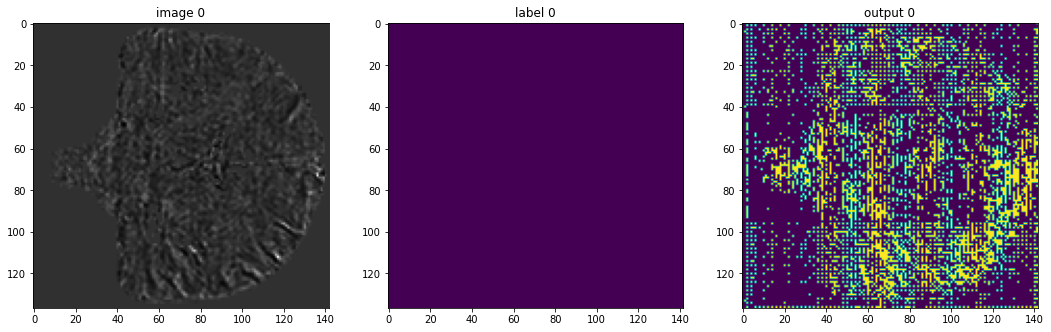

label: tensor(0.)
output: tensor(1)


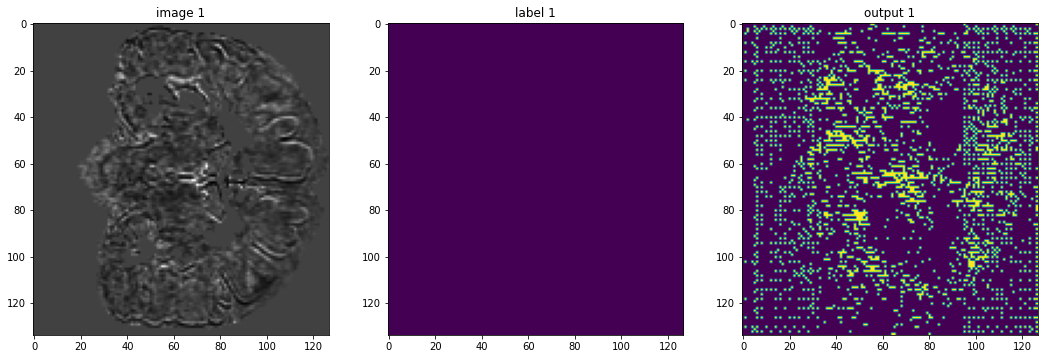

label: tensor(1.)
output: tensor(1)


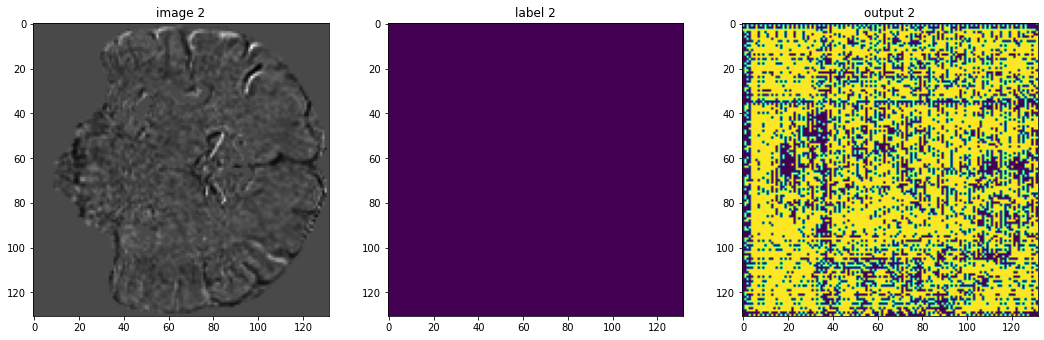

label: tensor(1.)
output: tensor(1)


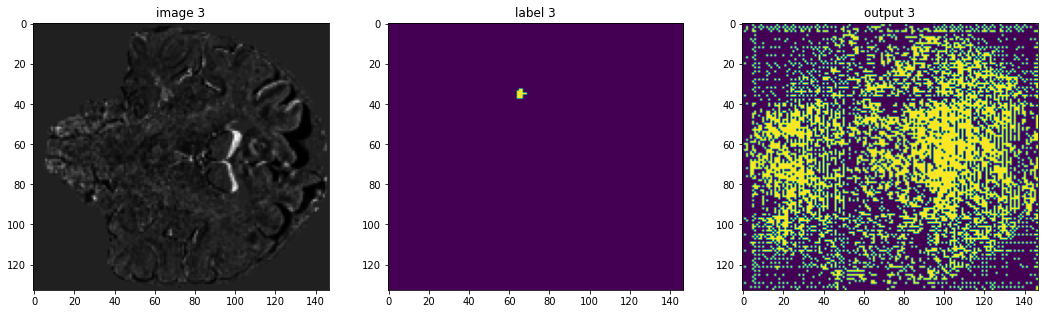

label: tensor(1.)
output: tensor(1)


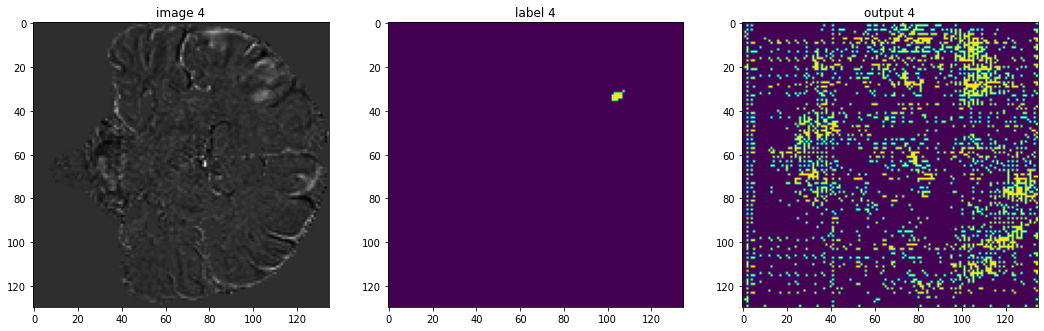

label: tensor(0.)
output: tensor(1)


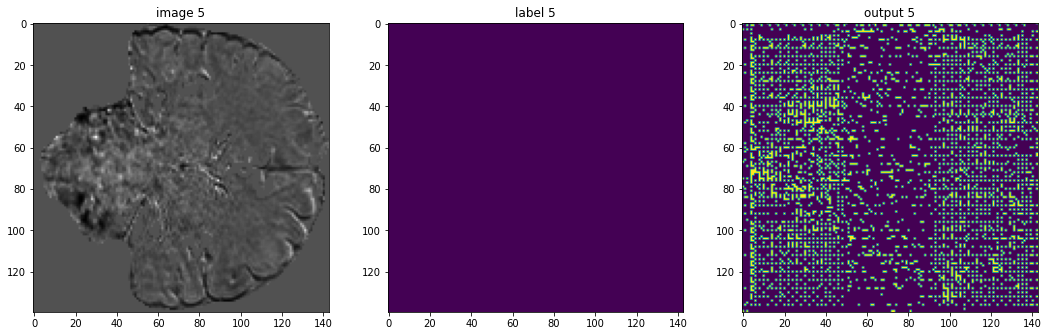

label: tensor(1.)
output: tensor(1)


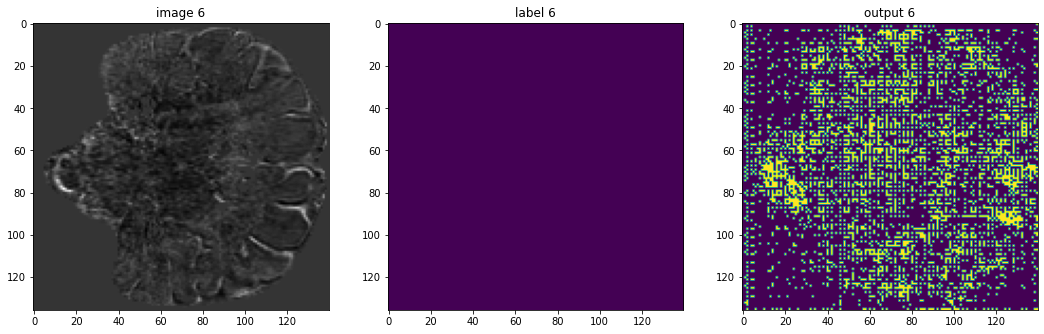

label: tensor(1.)
output: tensor(1)


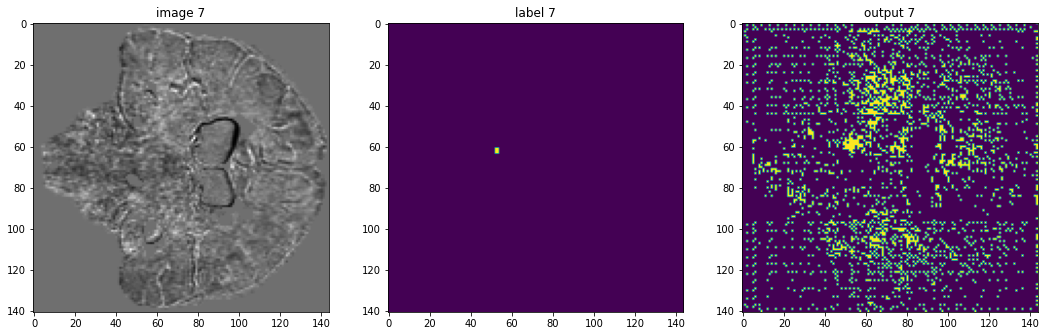

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
layer = 81
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (96, 96, 96)
        sw_batch_size = 4
        # inputs = (val_data["image"] - val_data["first_image"]).to(device)
        inputs = val_data["diff_image"].to(device)
        val_outputs = sliding_window_inference(
            inputs, roi_size, sw_batch_size, model
        )
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["diff_image"][0, 0, :, layer, :], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        print("label:", torch.max(val_data["label"][0, 0, :, :, :]))
        plt.imshow(val_data["label"][0, 0, :, layer, :])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        output = torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, :]
        print("output:", torch.max(output))
        # print(((val_data["label"][0,0,:,:,:] == 1).nonzero(as_tuple=True)))
        plt.imshow(output[:, layer, :])
        plt.show()
        if i == 10:
            break